# This is the codebase for validation of VASARI-auto

###	vasari-auto.py | a pipeline for automated VASARI characterisation of glioma.

###	Copyright 2024 James Ruffle, High-Dimensional Neurology, UCL Queen Square Institute of Neurology.

###	This program is licensed under the APACHE 2.0 license.

###	This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  

###	See the License for more details.

###	This code is part of the repository https://github.com/james-ruffle/vasari-auto

###	Correspondence to Dr James K Ruffle by email: j.ruffle@ucl.ac.uk

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [2]:
#Import packages
import glob
import numpy as np
import os
import pandas as pd
import shutil
import errno
import subprocess
from datetime import datetime
from tqdm import tqdm
import argparse
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import seaborn as sns
from sklearn.metrics import *
import time
from skimage.morphology import skeletonize
import matplotlib.ticker as mticker
from scipy import stats
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy
from sklearn.metrics import cohen_kappa_score
import sklearn

In [3]:
desktop = False
mac = False
 
if desktop:
    user = 'jamesruffle'
if not desktop:
    user = 'jruffle'

if mac:
    user = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/'
if not mac:
    user = '/home/'+str(user)+'/OneDrive/'

In [4]:
#where annotated nifti segmentations will be pulled from
seg_path = str(user)+'PhD/VASARI/data/RADIOLOGISTS/IMAGES/'

#atlas paths
atlases = str(user)+'PhD/VASARI/TUTORIAL/atlas_masks/'

#consultant neuroradiologist validation
df = pd.read_excel(str(user)+'PhD/VASARI/data/labelled_data/merged_radiologist_labelled_data.xlsx',index_col=0)
for i, row in df.iterrows():
    if 'UCSF' in df.loc[i,'filename']:
        padded_num = row['filename'].split('-')[-1].zfill(4)
        df.loc[i,'filename'] = 'UCSF-PDGM-'+str(padded_num)

#segmentations to evaluate
model_prediction = str(user)+'PhD/forFAITH/model_prediction/'
neurorad_hand_label = str(user)+'PhD/forFAITH/neurorad_hand_label/'

neurorad_hand_label_subs = df['filename'].values

figures_out = str(user)+'PhD/VASARI/Results/figs_output/'

print("Number of lesions: "+str(len(neurorad_hand_label_subs)))
print('')
print('#unique lesions: '+str(len(df['filename'].unique())))
print('')
print('#number double reported for inter-rater variability: '+str(len(neurorad_hand_label_subs)-len(df['filename'].unique())))

Number of lesions: 100

#unique lesions: 87

#number double reported for inter-rater variability: 13


In [5]:
time_str = '8m 43s'
time_str

def time_string_to_seconds(time_str):
    minutes, seconds = int(time_str.split('m')[0]), int(time_str.split('m')[-1].split('s')[0])
    total_seconds = minutes * 60 + seconds
    return total_seconds

for i, row in tqdm(df.iterrows(),total=len(df)):
    df.loc[i,'time_taken_seconds']=time_string_to_seconds(row['time_taken_seconds'])

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7034.83it/s]


In [6]:
col_names = ['filename', 'reporter', 'time_taken_seconds',
           'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
           'F3 Eloquent Brain', 'F4 Enhancement Quality',
           'F5 Proportion Enhancing', 'F6 Proportion nCET',
           'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
           'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
           'F12 Definition of the Enhancing margin',
           'F13 Definition of the non-enhancing tumour margin',
           'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
           'F18 Pial invasion', 'F19 Ependymal Invasion',
           'F20 Cortical involvement', 'F21 Deep WM invasion', 
                 'F22 nCET Crosses Midline', 'F23 CET Crosses midline',
                 'F24 satellites',
           'F25 Calvarial modelling', 'COMMENTS']

new_dataframe_for_modelling_hand_label = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_hand_label['filename']=neurorad_hand_label+neurorad_hand_label_subs+'.nii.gz'

new_dataframe_for_modelling_tumour_seg = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_tumour_seg['filename']=model_prediction+neurorad_hand_label_subs+'.nii.gz'

In [7]:
from vasari_auto import get_vasari_features

In [8]:
for i, row in tqdm(new_dataframe_for_modelling_hand_label.iterrows(),total=len(new_dataframe_for_modelling_hand_label)):
    result = get_vasari_features(file=row['filename'])
    new_dataframe_for_modelling_hand_label.iloc[i,:]=result.values[0]

100%|█████████████████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


In [9]:
for i, row in tqdm(new_dataframe_for_modelling_tumour_seg.iterrows(),total=len(new_dataframe_for_modelling_tumour_seg)):
    result = get_vasari_features(file=row['filename'])
    new_dataframe_for_modelling_tumour_seg.iloc[i,:]=result.values[0]

100%|█████████████████████████████████████████| 100/100 [04:49<00:00,  2.90s/it]


In [10]:
all_data = pd.concat([df,new_dataframe_for_modelling_hand_label,new_dataframe_for_modelling_tumour_seg]).reset_index(drop=True)
all_data['time_taken_seconds'] = all_data['time_taken_seconds'].astype(float)
all_data['mode']='Consultant\nNeuroradiologist'
all_data.loc[all_data['reporter']=='VASARI-auto','mode']='VASARI-auto'
all_data.loc[all_data['reporter']=='KPB','reporter']='#1'
all_data.loc[all_data['reporter']=='HH','reporter']='#2'
all_data.rename(columns={'reporter':'Reporter'},inplace=True)
all_data['DataOrigin']='HandDrawn'

for i, row in all_data.iterrows():
    if 'model_prediction' in all_data.loc[i,'filename']:
        all_data.loc[i,'DataOrigin']='TumourSeg'
        
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('/')[-1]
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('.nii.gz')[0]

In [11]:
all_data.columns

Index(['filename', 'OS', 'Reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS', 'F22 nCET Crosses Midline',
       'F23 CET Crosses midline', 'mode', 'DataOrigin'],
      dtype='object')

In [12]:
def get_ytrue_ypred(df=all_data,hand_drawn_only=True):
    y_true = df.loc[df['mode']=='Consultant\nNeuroradiologist']
    y_pred = df.loc[df['mode']=='VASARI-auto']

    if hand_drawn_only:
        y_pred = y_pred.loc[y_pred['DataOrigin']=='HandDrawn']
    
    y_true = y_true.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    y_pred = y_pred.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    
    if list(y_true['filename']) != list(y_pred['filename']):
        print('MISMATCH!')
    
    return y_true, y_pred

In [46]:
y_true, y_pred = get_ytrue_ypred()
vasari_metric='F4 Enhancement Quality'

print(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))
print(sklearn.metrics.balanced_accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))

# sklearn.metrics.balanced_accuracy_score

cm = confusion_matrix(y_true[vasari_metric].values.astype(int), y_pred=y_pred[vasari_metric].values.astype(int),labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp.plot()
plt.title(vasari_metric)

ValueError: cannot convert float NaN to integer

In [49]:
y_pred

,filename,OS,Reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,F8 Cyst(s),F9 Multifocal or Multicentric,F10 T1/FLAIR Ratio,F11 Thickness of enhancing margin,F12 Definition of the Enhancing margin,F13 Definition of the non-enhancing tumour margin,F14 Proportion of Oedema,F16 haemorrhage,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS,F22 nCET Crosses Midline,F23 CET Crosses midline,mode,DataOrigin
0,UCSF-PDGM-0005,NaN,VASARI-auto,3.037011,8,1,NaN,2,4,4,4,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,1,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
1,UCSF-PDGM-0007,NaN,VASARI-auto,3.088620,2,1,NaN,2,4,3,3,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,2,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
2,UCSF-PDGM-0029,NaN,VASARI-auto,3.160334,4,3,NaN,2,4,3,3,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,3,VASARI-auto,HandDrawn
3,UCSF-PDGM-0032,NaN,VASARI-auto,3.159800,2,3,NaN,3,5,4,4,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
4,UCSF-PDGM-0232,NaN,VASARI-auto,3.619876,1,1,NaN,1,3,3,2,1,1,NaN,3,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
5,UCSF-PDGM-0243,NaN,VASARI-auto,3.338514,1,3,NaN,2,3,3,3,1,2,NaN,4,NaN,NaN,5,NaN,NaN,NaN,1,1,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
6,UCSF-PDGM-0261,NaN,VASARI-auto,3.135529,2,3,NaN,1,3,3,2,1,1,NaN,3,NaN,NaN,5,NaN,NaN,NaN,1,2,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
7,UCSF-PDGM-0297,NaN,VASARI-auto,3.449203,4,1,NaN,3,4,4,4,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,1,NaN,Please note that this software is in beta and ...,2,3,VASARI-auto,HandDrawn
8,UCSF-PDGM-0336,NaN,VASARI-auto,3.033507,1,3,NaN,3,4,5,5,1,1,NaN,4,NaN,NaN,5,NaN,NaN,NaN,2,2,2,2,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn
9,UCSF-PDGM-0357,NaN,VASARI-auto,3.173247,2,3,NaN,2,4,3,2,1,1,NaN,5,NaN,NaN,5,NaN,NaN,NaN,1,1,1,1,NaN,Please note that this software is in beta and ...,2,2,VASARI-auto,HandDrawn


In [17]:
# y_pred

#cortical 72 with cortical_thresh=1000
#ependymal 79 with t_ependymal=5000, ( 3500 looked well calibrated)
#deep wm 74, t_w=100, trying 350 (150 not enough) ###though 350 looked reasonably well calibrated...
# satellites 86 at 20, trying 15 (10 is too much)

In [18]:
    # result = pd.DataFrame(columns=col_names)
    # result.loc[len(result)] = {'filename':file,
    #                            'reporter':'VASARI-auto',
    #                           'time_taken_seconds':time_taken,
    #                           'F1 Tumour Location':F1_dict[vols.iloc[0,0]], #vols.iloc[0,0],
    #                           'F2 Side of Tumour Epicenter':F2_dict[side],
    #                           'F3 Eloquent Brain':np.nan, #unsupported in current version
    #                           'F4 Enhancement Quality':enhancement_quality,
    #                           'F5 Proportion Enhancing':proportion_enhancing_f,
    #                           'F6 Proportion nCET':proportion_nonenhancing_f,
    #                           'F7 Proportion Necrosis':proportion_necrosis_f,
    #                           'F8 Cyst(s)':num_components_ncet_f,
    #                             'F9 Multifocal or Multicentric':f9_multifocal,
    #                            'F10 T1/FLAIR Ratio':np.nan,  #unsupported in current version
    #                            'F11 Thickness of enhancing margin':enhancing_thickness_f,
    #                            'F12 Definition of the Enhancing margin':np.nan,  #unsupported in current version
    #                            'F13 Definition of the non-enhancing tumour margin':np.nan,  #unsupported in current version
    #                            'F14 Proportion of Oedema': proportion_oedema_f,
    #                            'F16 haemorrhage':np.nan,  #unsupported in current version
    #                            'F17 Diffusion':np.nan,  #unsupported in current version
    #                            'F18 Pial invasion':np.nan, #unsupported in current version
    #                            'F19 Ependymal Invasion':ependymal, 
    #                            'F20 Cortical involvement':cortical_lesioned_voxels_f,
    #                            'F21 Deep WM invasion':deep_wm_f, 
    #                            'F22 nCET Crosses Midline':nCET_cross_midline_f,
    #                            'F23 CET Crosses midline':CET_cross_midline_f,
    #                            'F24 satellites':num_components_cet_f, 
    #                            'F25 Calvarial modelling':np.nan, #unsupported in current version
    #                            'COMMENTS':'Please note that this software is in beta and utilises only irrevocably anonymised lesion masks. VASARI features that require source data shall not be derived and return NaN'
    #                           }

In [118]:
balanced_accuracy_dict = {}

for c in all_data.columns:
    vasari_metric=c
    try:
        print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
        balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))
    except:
        balanced_accuracy_dict[c]=0

del balanced_accuracy_dict['time_taken_seconds']
del balanced_accuracy_dict['OS']
del balanced_accuracy_dict['Reporter']
del balanced_accuracy_dict['filename']
del balanced_accuracy_dict['COMMENTS']
del balanced_accuracy_dict['mode']
del balanced_accuracy_dict['DataOrigin']

del balanced_accuracy_dict['F3 Eloquent Brain']
del balanced_accuracy_dict['F10 T1/FLAIR Ratio']
del balanced_accuracy_dict['F12 Definition of the Enhancing margin']
del balanced_accuracy_dict['F13 Definition of the non-enhancing tumour margin']
del balanced_accuracy_dict['F16 haemorrhage']
del balanced_accuracy_dict['F17 Diffusion']
del balanced_accuracy_dict['F18 Pial invasion']
del balanced_accuracy_dict['F25 Calvarial modelling']
del balanced_accuracy_dict['F8 Cyst(s)']

OS 0.0
time_taken_seconds 0.0
F1 Tumour Location 0.8045977011494253
F2 Side of Tumour Epicenter 0.9655172413793104
F5 Proportion Enhancing 0.4942528735632184
F6 Proportion nCET 0.20689655172413793
F7 Proportion Necrosis 0.5172413793103449
F8 Cyst(s) 0.39080459770114945
F9 Multifocal or Multicentric 0.7011494252873564
F11 Thickness of enhancing margin 0.6781609195402298
F14 Proportion of Oedema 0.3218390804597701
F19 Ependymal Invasion 0.7931034482758621
F20 Cortical involvement 0.7241379310344828
F21 Deep WM invasion 0.735632183908046
F24 satellites 0.8620689655172413


/tmp/ipykernel_3944690/1064551506.py:6: RuntimeWarning: invalid value encountered in cast
  print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
/tmp/ipykernel_3944690/1064551506.py:7: RuntimeWarning: invalid value encountered in cast
  balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))


In [100]:
accuracy_metrics = pd.DataFrame(list(balanced_accuracy_dict.values()),columns=['Neuroradiologist:VASARI-auto accuracy'])
accuracy_metrics['Feature']=list(balanced_accuracy_dict.keys())
accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto agreement']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']=0
accuracy_metrics

,Neuroradiologist:VASARI-auto Accuracy,Feature,Neuroradiologist VASARI without segmentation (GT):VASARI-auto Agreement,VASARI-auto Neuroradiologist hand segmentation (GT):Tumour Segmentation Accuracy,VASARI-auto Neuroradiologist segmentation (GT):Tumour Segmentation Agreement
0,0.804598,F1 Tumour Location,0,0,0
1,0.965517,F2 Side of Tumour Epicenter,0,0,0
2,0.000000,F4 Enhancement Quality,0,0,0
3,0.494253,F5 Proportion Enhancing,0,0,0
4,0.206897,F6 Proportion nCET,0,0,0
5,0.517241,F7 Proportion Necrosis,0,0,0
6,0.390805,F8 Cyst(s),0,0,0
7,0.701149,F9 Multifocal or Multicentric,0,0,0
8,0.678161,F11 Thickness of enhancing margin,0,0,0
9,0.321839,F14 Proportion of Oedema,0,0,0


In [116]:
for i, row in accuracy_metrics.iterrows():
    metric = row['Feature']
    print(metric)
    
    hand_annotation_vasari_auto = new_dataframe_for_modelling_hand_label[metric].values.astype(int)
    tumour_seg_vasari_auto = new_dataframe_for_modelling_tumour_seg[metric].values.astype(int)

    try:
        radiologist_vasari_only = df[metric].values.astype(int)
    except:
        radiologist_vasari_only = np.zeros(shape=tumour_seg_vasari_auto.shape)

    hand_segment_accuracy = accuracy_score(y_true=hand_annotation_vasari_auto,y_pred=tumour_seg_vasari_auto)
    hand_segment_agreement = cohen_kappa_score(y1=hand_annotation_vasari_auto,y2=tumour_seg_vasari_auto,weights=None)
    neuroradiologist_vasari_only_agreement = cohen_kappa_score(y1=radiologist_vasari_only,y2=tumour_seg_vasari_auto,weights=None)

    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=neuroradiologist_vasari_only_agreement
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy']=hand_segment_accuracy
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement']=hand_segment_agreement

F1 Tumour Location
F2 Side of Tumour Epicenter
F4 Enhancement Quality
F5 Proportion Enhancing
F6 Proportion nCET
F7 Proportion Necrosis
F8 Cyst(s)
F9 Multifocal or Multicentric
F11 Thickness of enhancing margin
F14 Proportion of Oedema
F19 Ependymal Invasion
F20 Cortical involvement
F21 Deep WM invasion
F24 satellites
F22 nCET Crosses Midline
F23 CET Crosses midline


/tmp/ipykernel_3944690/2393553241.py:9: RuntimeWarning: invalid value encountered in cast
  radiologist_vasari_only = df[metric].values.astype(int)


In [117]:
accuracy_metrics

,Neuroradiologist:VASARI-auto Accuracy,Feature,Neuroradiologist VASARI without segmentation (GT):VASARI-auto Agreement,VASARI-auto Neuroradiologist hand segmentation (GT):Tumour Segmentation Accuracy,VASARI-auto Neuroradiologist segmentation (GT):Tumour Segmentation Agreement,Neuroradiologist VASARI (GT):VASARI-auto agreement,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model accuracy,VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using Tumour Segmentation model agreement
0,0.804598,F1 Tumour Location,0,0,0,0.748710,0.99,0.986389
1,0.965517,F2 Side of Tumour Epicenter,0,0,0,0.929553,0.99,0.981998
2,0.000000,F4 Enhancement Quality,0,0,0,0.328859,0.98,0.957483
3,0.494253,F5 Proportion Enhancing,0,0,0,0.300808,0.93,0.864760
4,0.206897,F6 Proportion nCET,0,0,0,-0.082651,0.95,0.913704
5,0.517241,F7 Proportion Necrosis,0,0,0,0.373309,0.95,0.920936
6,0.390805,F8 Cyst(s),0,0,0,0.197248,0.33,0.018171
7,0.701149,F9 Multifocal or Multicentric,0,0,0,0.000000,0.97,0.000000
8,0.678161,F11 Thickness of enhancing margin,0,0,0,0.243499,1.00,1.000000
9,0.321839,F14 Proportion of Oedema,0,0,0,0.002313,1.00,1.000000


In [24]:
# y_pred.columns

In [25]:
# print(*(p for p,v in enumerate(zip(list(y_pred[vasari_metric]),list(y_true[vasari_metric]))) if v[0]^v[1]))

In [26]:
# index = 3

In [40]:
# y_true.iloc[index,:]

In [41]:
# y_pred.iloc[index,:]

2.346524295266494e-137


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


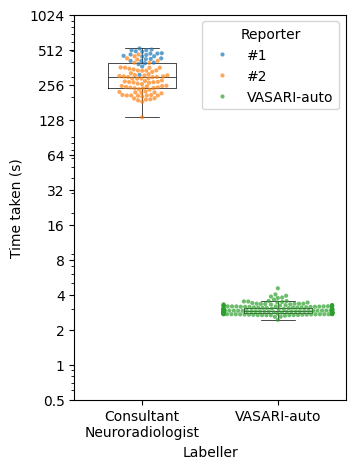

In [29]:
x='mode'
y='time_taken_seconds'

tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
print(tt.pvalue)

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=all_data,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.savefig(figures_out+"efficiency.png",dpi=150,bbox_inches='tight')

In [30]:
v = df.filename.value_counts()
duplicates = df[df.filename.isin(v.index[v.gt(1)])]
duplicate_files = duplicates.loc[duplicates['reporter']=='KPB','filename'].values
drop_cols = ['filename','OS','reporter','time_taken_seconds','F17 Diffusion','F25 Calvarial modelling','COMMENTS','F3 Eloquent Brain','F12 Definition of the Enhancing margin','F13 Definition of the non-enhancing tumour margin']

def flatten(xss):
    return [x for xs in xss for x in xs]

duplicate_files

array(['UCSF-PDGM-0486', 'UPENN-GBM-00159_11', 'UPENN-GBM-00054_11',
       'UPENN-GBM-00031_11', 'UPENN-GBM-00349_11', 'UPENN-GBM-00127_11',
       'UPENN-GBM-00255_11', 'UPENN-GBM-00180_11'], dtype=object)

In [31]:
labeler0=[]
labeler1=[]
reporters = ['KPB','HH']

for d in range(len(duplicate_files)):

    for r in range(len(reporters)):
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy()
        reporter_vals.drop(drop_cols,axis=1,inplace=True)

        if r == 0:
            labeler0.append(reporter_vals.values[0])
        if r == 1:
            labeler1.append(reporter_vals.values[0])
labeler0 = flatten(labeler0)
labeler1 = flatten(labeler1)

In [32]:
reporter1 = pd.DataFrame(labeler0,columns=['VASARI'])
reporter1['Reporter']='#1'
reporter2 = pd.DataFrame(labeler1,columns=['VASARI'])
reporter2['Reporter']='#2'

reporters = pd.concat([reporter1,reporter2])
reporters

,VASARI,Reporter
0,2.0,#1
1,3.0,#1
2,2.0,#1
3,3.0,#1
4,7.0,#1
5,2.0,#1
6,1.0,#1
7,1.0,#1
8,3.0,#1
9,5.0,#1


0.49931422796506164


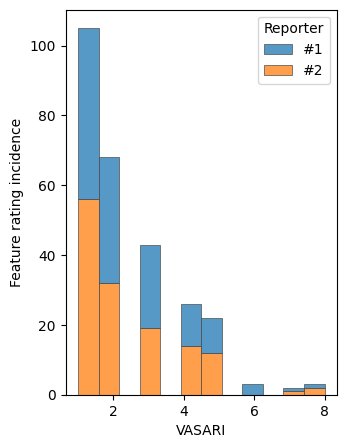

In [33]:
print(cohen_kappa_score(labeler0, labeler1,weights=None))

plt.figure(figsize=(3.5,5))

ax = sns.histplot(data=reporters,x='VASARI',hue='Reporter',multiple='stack',edgecolor=".3",
    linewidth=.5)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Feature rating incidence')

plt.savefig(figures_out+"inter-rater.png",dpi=150,bbox_inches='tight')

In [35]:
enhancing_label=3
nonenhancing_label=1
oedema_label=2
from torch import tensor
from torchmetrics.classification import Dice
dice = Dice(average='micro')
all_molecular_data = pd.read_csv('/mnt/wwn-0x5002538f4132e495/brc3_rsync/NEUROONCOLOGY/DATA/DEEP_TOPOLOGY_OUTPUTS/processed_csv/'+'all_molecular_data.csv',index_col=0)

dice_df = pd.DataFrame(columns=['filename','filename_hand_label','filename_tumour_seg_label','Abnormality','Perilesional signal change','Nonenhancing tumour','Enhancing tumour','Age','Sex'])
dice_df['filename']=neurorad_hand_label_subs
dice_df['filename_hand_label']= new_dataframe_for_modelling_hand_label['filename']
dice_df['filename_tumour_seg_label']= new_dataframe_for_modelling_tumour_seg['filename']

for i, row in tqdm(dice_df.iterrows(),total=len(dice_df)):
    seg_hand_label = np.asanyarray(nib.load(row['filename_hand_label']).dataobj)
    seg_tumour_seg = np.asanyarray(nib.load(row['filename_tumour_seg_label']).dataobj)

    if i==0:
        hand_label_stack = np.zeros(shape=seg_hand_label.shape)
        tumour_seg_stack = np.zeros(shape=seg_hand_label.shape)
    
    #abnormality
    seg_hand_label_abnormality = seg_hand_label.copy()
    seg_hand_label_abnormality[seg_hand_label_abnormality>0]=1
    seg_tumour_seg_abnormality = seg_tumour_seg.copy()
    seg_tumour_seg_abnormality[seg_tumour_seg_abnormality>0]=1
    dice_abnormality = dice(tensor(seg_tumour_seg_abnormality,dtype=int), tensor(seg_hand_label_abnormality,dtype=int))
    hand_label_stack+=seg_hand_label_abnormality
    tumour_seg_stack+=seg_tumour_seg_abnormality
    
    #oedema
    seg_hand_label_oedema = seg_hand_label.copy()
    seg_hand_label_oedema[seg_hand_label_oedema!=oedema_label]=0
    seg_hand_label_oedema[seg_hand_label_oedema>0]=1
    seg_tumour_seg_oedema = seg_tumour_seg.copy()
    seg_tumour_seg_oedema[seg_tumour_seg_oedema!=oedema_label]=0
    seg_tumour_seg_oedema[seg_tumour_seg_oedema>0]=1
    dice_oedema = dice(tensor(seg_tumour_seg_oedema,dtype=int), tensor(seg_hand_label_oedema,dtype=int))
    
    #net
    seg_hand_label_net = seg_hand_label.copy()
    seg_hand_label_net[seg_hand_label_net!=nonenhancing_label]=0
    seg_hand_label_net[seg_hand_label_net>0]=1
    seg_tumour_seg_net = seg_tumour_seg.copy()
    seg_tumour_seg_net[seg_tumour_seg_net!=nonenhancing_label]=0
    seg_tumour_seg_net[seg_tumour_seg_net>0]=1
    dice_net = dice(tensor(seg_tumour_seg_net,dtype=int), tensor(seg_hand_label_net,dtype=int))
    
    #et
    seg_hand_label_et = seg_hand_label.copy()
    seg_hand_label_et[seg_hand_label_et!=enhancing_label]=0
    seg_hand_label_et[seg_hand_label_et>0]=1
    seg_tumour_seg_et = seg_tumour_seg.copy()
    seg_tumour_seg_et[seg_tumour_seg_et!=enhancing_label]=0
    seg_tumour_seg_et[seg_tumour_seg_et>0]=1
    dice_et = dice(tensor(seg_tumour_seg_et,dtype=int), tensor(seg_hand_label_et,dtype=int))

    dice_df.loc[i,'Abnormality']=dice_abnormality.numpy()
    dice_df.loc[i,'Perilesional signal change']=dice_oedema.numpy()
    dice_df.loc[i,'Nonenhancing tumour']=dice_net.numpy()
    dice_df.loc[i,'Enhancing tumour']=dice_et.numpy()

    mrn = row['filename']
    if len(all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'])==0 and 'UCSF' in mrn:
        mrn = 'UCSF-PDGM-'+str(int(mrn.split('-')[-1])).zfill(3)
    
    dice_df.loc[i,'Age']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'].values[0]
    dice_df.loc[i,'Sex']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Male'].values[0]

dice_df.loc[dice_df['Sex']==1,'Sex']='Male'
dice_df.loc[dice_df['Sex']==0,'Sex']='Female'
affine = nib.load(row['filename_hand_label']).affine
hand_label_stack_nii = nib.Nifti1Image(hand_label_stack,affine=affine)
tumour_seg_stack_nii = nib.Nifti1Image(tumour_seg_stack,affine=affine)
nib.save(hand_label_stack_nii,figures_out+"hand_label_stack_nii.nii.gz")
nib.save(tumour_seg_stack_nii,figures_out+"tumour_seg_stack_nii.nii.gz")

100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


In [36]:
dice_df.head()

,filename,filename_hand_label,filename_tumour_seg_label,Abnormality,Perilesional signal change,Nonenhancing tumour,Enhancing tumour,Age,Sex
0,UPENN-GBM-00575_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99744153,0.99802494,0.9984387,0.996771,76.93,Female
1,UPENN-GBM-00589_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9989256,0.99859107,0.9995744,0.9991194,80.93,Male
2,UPENN-GBM-00591_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.99903256,0.99891984,0.99991786,0.9998196,75.92,Male
3,UPENN-GBM-00601_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9968144,0.9966427,0.99945426,0.9989454,59.69,Male
4,UPENN-GBM-00604_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,0.9991101,0.9989518,0.9994659,0.99878967,62.0,Female


In [37]:
dice_df.rename(columns={'Abnormality':'WT','Perilesional signal change':'PS','Nonenhancing tumour':'NET','Enhancing tumour':'ET'},inplace=True)
dice_df_melt = pd.melt(dice_df,id_vars=['filename','filename_hand_label','filename_tumour_seg_label','Sex','Age'])
dice_df_melt['value']=dice_df_melt['value'].astype(float)
dice_df_melt['Age']=dice_df_melt['Age'].astype(float)
dice_df_melt

,filename,filename_hand_label,filename_tumour_seg_label,Sex,Age,variable,value
0,UPENN-GBM-00575_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,76.93,WT,0.997442
1,UPENN-GBM-00589_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,80.93,WT,0.998926
2,UPENN-GBM-00591_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,75.92,WT,0.999033
3,UPENN-GBM-00601_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,59.69,WT,0.996814
4,UPENN-GBM-00604_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,62.00,WT,0.999110
5,UPENN-GBM-00611_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,58.09,WT,0.997355
6,UCSF-PDGM-0486,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,54.00,WT,0.999228
7,UPENN-GBM-00159_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,63.88,WT,0.997439
8,UPENN-GBM-00054_11,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Female,39.88,WT,0.995755
9,UCSF-PDGM-0243,/home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...,/home/jruffle/OneDrive/PhD/forFAITH/model_pred...,Male,59.00,WT,0.999543


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


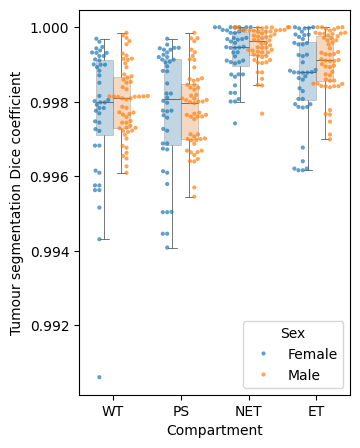

In [38]:
x='variable'
y='value'
h='Sex'

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(xlabel='Compartment')
ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"dice_equitable_sex.png",dpi=150,bbox_inches='tight')

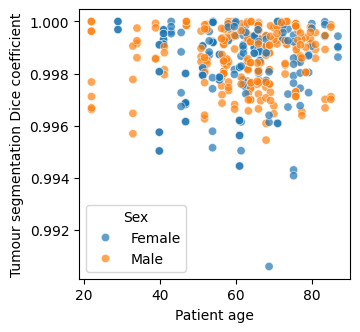

In [39]:
x='Age'
y='value'
h='Sex'

plt.figure(figsize=(3.5,3.5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df_melt,x=x,y=y,hue=h,alpha=.7)

ax.set(xlabel='Patient age')
ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')